In [1]:
import decode_eeg
import numpy as np
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)

# Color to Orientation

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [4]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle, isub)

# Set up interp object and save results.
interp_color = decode_eeg.Interpreter(clfr,subtitle=f'color_to_ori_trialbin{trial_average}_')
interp_color.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [12]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_color = decode_eeg.Interpreter()
interp_color.load_results(filename = 'color_to_ori_trialbin20.pickle')

# Orientation to Color

In [10]:
# Classification parameters and setup

time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [12]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub,sub in enumerate(sync.matched_ids):
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# setup interp object and save results
interp = decode_eeg.Interpreter(clfr,subtitle=f'ori_to_color_{trial_average}_')
interp.save_results()

In [32]:
# Set up interp object and load pre-existing results.
interp = decode_eeg.Interpreter()
interp.load_results('ori_to_color_trialbin20.pickle')

# Plot both directions of classification generalization

In [33]:
# Combine acc matrices for plotting
interp.acc = np.concatenate([interp.acc[:,np.newaxis],interp_color.acc[:,np.newaxis]],1)
interp.acc_shuff = np.concatenate([interp.acc_shuff[:,np.newaxis],interp_color.acc_shuff[:,np.newaxis]],1)

Saving output\figures\acc20210601_1146.pdf
Saving output\figures\acc20210601_1146.png


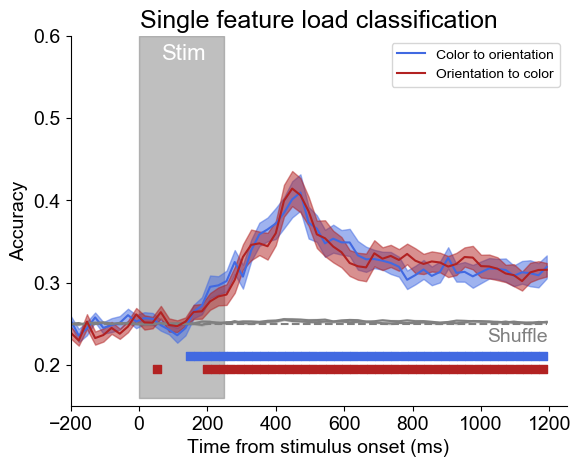

In [49]:
interp.plot_acc_subset(
    subset_list=['Color to orientation','Orientation to color'],
    ylim=[.15,.6], 
    chance=.25, 
    sig_ys=[.21,.195], 
    chance_text_y=.211,
    significance_testing=True,
    title='Single feature load classification',
    savefig=True)